## Crypto Clustering Project (Market Movement Approach)

In [5]:
import csv
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import pickle as pk
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
import hvplot.pandas 
%matplotlib inline

### Reading the Top 100 Crypto in CoinGecko

In [6]:
data = pd.read_csv("data/raw/coin_market_1.csv")
coindf = data.copy()

In [7]:
coindf.head()

,id,symbol,name,hashing_algo,market_cap,rank,interest_score,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,twt_followers,rdt_followers
0,bitcoin,btc,Bitcoin,SHA-256,1,1,0.341,2.51977,-4.58115,5.41309,-7.70834,839265356719,2.100000e+07,1.895990e+07,4677076,3911324
1,ethereum,eth,Ethereum,Ethash,2,2,0.701,-6.25679,-19.05058,27.77369,77.18060,377060274860,NaN,1.196021e+08,2225564,1230328
2,tether,usdt,Tether,NaN,3,146,0.071,0.05774,0.24979,-0.12995,0.07017,78725451792,7.864105e+10,7.864105e+10,207281,0
3,binancecoin,bnb,BNB,NaN,4,4,20.192,-13.25981,-17.85405,34.00305,234.28903,72869407075,1.681370e+08,1.681370e+08,7674506,801012
4,usd-coin,usdc,USD Coin,NaN,5,57,0.086,-0.00990,-0.01310,-0.60260,0.02873,52574341888,5.255863e+10,5.255862e+10,0,0


In [8]:
coindf.describe(include='all')

,id,symbol,name,hashing_algo,market_cap,rank,interest_score,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,twt_followers,rdt_followers
count,100,100,100,22,100.000000,100.0000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000e+02,9.200000e+01,1.000000e+02,1.000000e+02,1.000000e+02
unique,100,100,100,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,eos,etc,TerraUSD,Ethash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,50.500000,188.0600,0.514800,-13.040953,-4.511066,116.421981,4239.751547,1.956796e+10,2.189023e+13,1.502231e+13,5.758412e+05,1.405319e+05
std,NaN,NaN,NaN,NaN,29.011492,202.5297,2.103119,17.302718,38.548474,323.846592,40198.546816,9.160613e+10,1.458758e+14,1.077271e+14,1.014435e+06,4.776884e+05
min,NaN,NaN,NaN,NaN,1.000000,1.0000,0.000000,-44.606480,-52.439970,-68.368270,-79.328380,1.042124e+09,3.988408e+04,0.000000e+00,0.000000e+00,0.000000e+00
25%,NaN,NaN,NaN,NaN,25.750000,25.7500,0.034250,-26.150750,-21.597980,-23.279637,-9.624280,1.648501e+09,1.846829e+08,7.508447e+07,1.384490e+05,0.000000e+00
50%,NaN,NaN,NaN,NaN,50.500000,111.0000,0.077500,-13.169895,-10.139725,5.527850,15.646745,2.875623e+09,1.000000e+09,4.399528e+08,2.490155e+05,1.841900e+04
75%,NaN,NaN,NaN,NaN,75.250000,294.5000,0.273250,-0.449863,-0.009848,90.380273,189.239702,6.499715e+09,1.000000e+10,6.680323e+09,5.855278e+05,6.564250e+04


#### Data Pre-Processing

In [9]:
coindf['total_followers'] = (coindf['twt_followers'] + coindf['rdt_followers'])

In [10]:
coindf = coindf.dropna(subset=['market_cap', 'rank', 'interest_score', 'p_change_30d', 
                                'p_change_60d', 'p_change_200d', 'p_change_1y', 'market_cap_usd', 
                                'total_supply', 'circulating_supply', 'twt_followers', 'rdt_followers'])

In [11]:
coindf = coindf[coindf['total_followers'] > 0]
coindf = coindf[coindf['p_change_60d'] != 0]
coindf = coindf[coindf['p_change_200d'] != 0]
coindf = coindf[coindf['p_change_1y'] != 0]

In [12]:
coindf.describe(include='all')

,id,symbol,name,hashing_algo,market_cap,rank,interest_score,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,twt_followers,rdt_followers,total_followers
count,79,79,79,16,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,7.900000e+01,7.900000e+01,7.900000e+01,7.900000e+01,7.900000e+01,7.900000e+01
unique,79,79,79,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,compound-usd-coin,ftm,THORChain,Ethash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,50.949367,174.974684,0.585165,-13.497305,-8.799631,131.375532,5361.498838,1.829451e+10,1.269399e+13,6.968981e+12,6.031296e+05,1.265138e+05,7.296433e+05
std,NaN,NaN,NaN,NaN,29.781641,183.085238,2.344517,16.753993,22.774358,352.833292,45220.678011,9.452675e+10,1.125048e+14,6.178191e+13,1.065807e+06,4.606241e+05,1.389878e+06
min,NaN,NaN,NaN,NaN,1.000000,1.000000,0.000000,-44.606480,-52.439970,-68.368270,-79.328380,1.042124e+09,3.988408e+04,0.000000e+00,0.000000e+00,0.000000e+00,2.560200e+04
25%,NaN,NaN,NaN,NaN,25.500000,26.500000,0.037000,-26.909280,-22.562920,-22.156420,-15.895980,1.570714e+09,2.004491e+08,8.821483e+07,1.644310e+05,0.000000e+00,2.020735e+05
50%,NaN,NaN,NaN,NaN,50.000000,110.000000,0.079000,-12.802350,-12.167120,10.365750,28.180400,2.959570e+09,1.000000e+09,4.670095e+08,2.549920e+05,2.239600e+04,3.182220e+05
75%,NaN,NaN,NaN,NaN,77.500000,279.000000,0.307000,-0.295965,-0.203560,97.998180,256.992965,6.522391e+09,1.000000e+10,6.744512e+09,6.051195e+05,7.046900e+04,7.349725e+05


### Data Inspection

In [13]:
fig = px.box(coindf, x="market_cap", 
                   hover_data=['name'])
fig.show()

In [14]:
# sns.set(rc={'figure.figsize':(15,4)})
# sns.boxplot(coindf['p_change_1y'])
fig = px.box(coindf, x="p_change_1y", 
                   hover_data=['name'])
fig.show()

In [15]:
corr = coindf.corr()
fig = px.imshow(corr,  template="plotly")
fig.show()

### PCA - Find out the proper dimension

In [16]:
# Store the supplemetary information
coin_supp = coindf.reset_index()

In [17]:
# Drop columns that are not used in PCA
coin_pca = coindf.drop(columns=['twt_followers', 'rdt_followers'])


Standardization

In [18]:
# Standardization
sc = StandardScaler()
coin_standardized = sc.fit_transform(coin_pca.iloc[:, 7:])
coin_pca = pd.DataFrame(coin_standardized, columns = ['p_change_30d','p_change_60d','p_change_200d','p_change_1y',
                                                        'market_cap_usd','total_supply','circulating_supply','total_followers'])

In [19]:
coin_pca

,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,total_followers
0,0.962124,0.186413,-0.359284,-0.119492,8.740560,-0.113551,-0.113520,5.690409
1,0.814233,0.399890,-0.375094,-0.119319,0.643385,-0.112848,-0.112239,-0.378235
2,0.014266,-0.400111,-0.277736,-0.114106,0.581038,-0.113550,-0.113518,5.608673
3,1.219989,0.559773,-0.345157,-0.118164,0.231031,-0.112657,-0.112740,1.478464
4,-0.497223,-0.044646,-0.419200,-0.118693,0.182376,-0.113149,-0.112998,0.570228
...,...,...,...,...,...,...,...,...
74,-1.567381,1.446342,0.499568,-0.114441,-0.183044,-0.113462,-0.113464,-0.422429
75,-0.682689,3.652471,1.144858,-0.115000,-0.183133,-0.113550,-0.113518,-0.421011
76,0.450472,0.432371,-0.509508,-0.121086,-0.183364,-0.113549,-0.113517,-0.385776
77,-0.736446,-1.386965,-0.473475,-0.119363,-0.183416,-0.113551,-0.113519,-0.332541


Feature Scaling

In [20]:
# Feature Scaling
coin_pca['market_cap_usd'] *= 0.7
coin_pca['total_followers'] *= 0.5
# coin_pca['total_supply'] *= 0.7
# coin_pca['circulating_supply'] *= 0.7

In [21]:
coin_pca

,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,total_followers
0,0.962124,0.186413,-0.359284,-0.119492,6.118392,-0.113551,-0.113520,2.845204
1,0.814233,0.399890,-0.375094,-0.119319,0.450369,-0.112848,-0.112239,-0.189117
2,0.014266,-0.400111,-0.277736,-0.114106,0.406726,-0.113550,-0.113518,2.804336
3,1.219989,0.559773,-0.345157,-0.118164,0.161722,-0.112657,-0.112740,0.739232
4,-0.497223,-0.044646,-0.419200,-0.118693,0.127664,-0.113149,-0.112998,0.285114
...,...,...,...,...,...,...,...,...
74,-1.567381,1.446342,0.499568,-0.114441,-0.128131,-0.113462,-0.113464,-0.211215
75,-0.682689,3.652471,1.144858,-0.115000,-0.128193,-0.113550,-0.113518,-0.210505
76,0.450472,0.432371,-0.509508,-0.121086,-0.128354,-0.113549,-0.113517,-0.192888
77,-0.736446,-1.386965,-0.473475,-0.119363,-0.128391,-0.113551,-0.113519,-0.166270


In [22]:
coin_cov = coin_pca.corr()

In [23]:
coin_cov

,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,total_followers
p_change_30d,1.000000,0.283088,-0.001502,0.101215,0.121261,0.101229,0.101421,0.140771
p_change_60d,0.283088,1.000000,0.158336,0.039647,0.020579,0.040151,0.040310,-0.013947
p_change_200d,-0.001502,0.158336,1.000000,0.092595,-0.044814,0.084833,0.084866,-0.050624
p_change_1y,0.101215,0.039647,0.092595,1.000000,-0.002172,0.999917,0.999918,0.211134
market_cap_usd,0.121261,0.020579,-0.044814,-0.002172,1.000000,-0.001505,-0.001492,0.707158
total_supply,0.101229,0.040151,0.084833,0.999917,-0.001505,1.000000,0.999999,0.210850
circulating_supply,0.101421,0.040310,0.084866,0.999918,-0.001492,0.999999,1.000000,0.210826
total_followers,0.140771,-0.013947,-0.050624,0.211134,0.707158,0.210850,0.210826,1.000000


<AxesSubplot:>

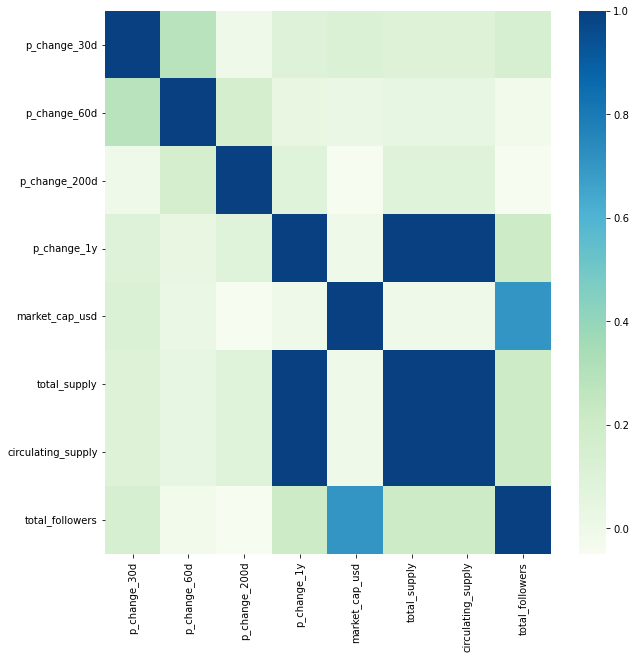

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(coin_cov, cmap = 'GnBu', ax=ax)

Get the eigenvalues and determine how many components we need

In [25]:
values, vectors = np.linalg.eig(coin_cov)
# print(values)
values_cul = np.cumsum(values)
# print(values_cul)
fig = px.line(values_cul, title='Cumulative Variance')
fig.show()

#### PCA Operation

In [26]:
coin_pca

,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,total_followers
0,0.962124,0.186413,-0.359284,-0.119492,6.118392,-0.113551,-0.113520,2.845204
1,0.814233,0.399890,-0.375094,-0.119319,0.450369,-0.112848,-0.112239,-0.189117
2,0.014266,-0.400111,-0.277736,-0.114106,0.406726,-0.113550,-0.113518,2.804336
3,1.219989,0.559773,-0.345157,-0.118164,0.161722,-0.112657,-0.112740,0.739232
4,-0.497223,-0.044646,-0.419200,-0.118693,0.127664,-0.113149,-0.112998,0.285114
...,...,...,...,...,...,...,...,...
74,-1.567381,1.446342,0.499568,-0.114441,-0.128131,-0.113462,-0.113464,-0.211215
75,-0.682689,3.652471,1.144858,-0.115000,-0.128193,-0.113550,-0.113518,-0.210505
76,0.450472,0.432371,-0.509508,-0.121086,-0.128354,-0.113549,-0.113517,-0.192888
77,-0.736446,-1.386965,-0.473475,-0.119363,-0.128391,-0.113551,-0.113519,-0.166270


In [27]:
pca_price = PCA(n_components=2)
pca_market = PCA(n_components=1)
pca_price.fit(coin_pca.iloc[:, 0:4])
pca_market.fit(coin_pca.iloc[:, 4:])
price_mvt = pca_price. transform(coin_pca.iloc[:, 0:4]) # the price movement
market_mvt = pca_market. transform(coin_pca.iloc[:, 4:]) # the market data
# pk.dump(pca_price, open("pca_price.pkl","wb"))
# pk.dump(pca_market, open("pca_market.pkl","wb"))


In [28]:
df1 = pd.DataFrame(data = price_mvt, columns = ['PCA1', 'PCA2'])
df2 = pd.DataFrame(data = market_mvt, columns = ['PCA3'])

In [29]:
coin_pca = df1.join(df2)

In [30]:
coin_pca

,PCA1,PCA2,PCA3
0,0.519304,-0.807629,0.164609
1,0.564657,-0.791154,-0.168972
2,-0.387346,-0.177755,0.086731
3,0.918231,-0.994946,-0.093039
4,-0.511062,-0.107663,-0.133099
...,...,...,...
74,0.155015,0.754184,-0.179700
75,2.335227,0.344992,-0.179740
76,0.322472,-0.720196,-0.178225
77,-1.540051,0.237483,-0.175936


### K-Means Clustering

#### Finding best value of K using Elbow Method

In [31]:
coin_pca

,PCA1,PCA2,PCA3
0,0.519304,-0.807629,0.164609
1,0.564657,-0.791154,-0.168972
2,-0.387346,-0.177755,0.086731
3,0.918231,-0.994946,-0.093039
4,-0.511062,-0.107663,-0.133099
...,...,...,...
74,0.155015,0.754184,-0.179700
75,2.335227,0.344992,-0.179740
76,0.322472,-0.720196,-0.178225
77,-1.540051,0.237483,-0.175936


In [32]:
wcss = []
k = list(range(1, 11))

# Calculate the wcss for the range of k values
for i in k:
    km = KMeans(n_clusters=i, init='k-means++', random_state=2)
    km.fit(coin_pca)
    wcss.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "wcss": wcss}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="wcss", xticks=k, title="Elbow Curve")

c:\Users\Jeff\anaconda3\envs\tensorflow-use-2\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



:Curve   [k]   (wcss)

#### The Best Value for `k` is 6 using the elbow curve

In [33]:
model = KMeans(n_clusters=6, init='k-means++', random_state=0)
# Fit the model
model.fit(coin_pca)
# Predict clusters
predictions = model.predict(coin_pca)

coin_pca['class'] = model.labels_

In [34]:
coin_class = coin_pca.join(coin_supp, how='outer')

### Visualization

In [35]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    coin_class,
    x="PCA1",
    y="PCA2",
    z="PCA3",
    hover_name='name',
    hover_data= ['p_change_30d', 'p_change_60d', 'p_change_200d', 'p_change_1y', 'market_cap_usd'],
    color="class",
    symbol="class",
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [36]:
# Formatting
# pd.options.display.float_format = '{:.4E}'.format
coin_class['market_cap_usd'] = coin_class['market_cap_usd'].apply(lambda x: float(x))

In [37]:
# Large, positive long term price movement, large market cap
coin_class[coin_class['class'] == 0].head(20)

,PCA1,PCA2,PCA3,class,index,id,symbol,name,hashing_algo,market_cap,...,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,twt_followers,rdt_followers,total_followers
24,4.181692,-2.606481,-0.156918,0,30,leo-token,leo,LEO Token,NaN,31,...,51.70822,59.46396,92.20095,289.17067,5.386082e+09,9.852395e+08,937161603.9,857014,9713,866727
50,1.918729,-1.745009,-0.175622,0,65,theta-fuel,tfuel,Theta Fuel,NaN,66,...,26.40541,16.04483,-31.02246,279.69690,1.886179e+09,5.301200e+09,0.0,249088,27818,276906


In [38]:
# Coins with price drop in recent two months with generally positive long-term reward
coin_class[coin_class['class'] == 1].head(10)

,PCA1,PCA2,PCA3,class,index,id,symbol,name,hashing_algo,market_cap,...,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,twt_followers,rdt_followers,total_followers
2,-0.387346,-0.177755,0.086731,1,3,binancecoin,bnb,BNB,NaN,4,...,-13.25981,-17.85405,34.00305,234.28903,7.286941e+10,1.681370e+08,1.681370e+08,7674506,801012,8475518
4,-0.511062,-0.107663,-0.133099,1,6,cardano,ada,Cardano,NaN,7,...,-21.77488,-9.80997,-15.59306,28.18040,3.542451e+10,4.500000e+10,3.206639e+10,825225,691934,1517159
5,-1.450283,0.895924,-0.131352,1,7,solana,sol,Solana,NaN,8,...,-30.06923,-41.14747,220.77086,1069.36435,3.312675e+10,5.081810e+08,3.192463e+08,1471408,129658,1601066
7,-0.519744,1.161480,-0.170878,1,9,terra-luna,luna,Terra,NaN,10,...,-33.34984,-12.16712,434.10779,967.40045,2.303276e+10,8.107375e+08,3.968598e+08,333946,30110,364056
8,-0.987674,0.252817,-0.144805,1,10,polkadot,dot,Polkadot,NaN,11,...,-28.37874,-19.78074,25.80152,-28.24553,2.158640e+10,1.165692e+09,1.084743e+09,1165928,38961,1204889
11,-0.545407,0.129369,-0.143372,1,14,matic-network,matic,Polygon,NaN,15,...,-21.77848,-14.56938,72.51902,1610.25615,1.254660e+10,1.000000e+10,6.872890e+09,1275092,0,1275092
16,-0.786771,0.150117,-0.157619,1,21,chainlink,link,Chainlink,NaN,22,...,-32.53527,-5.86128,-22.72346,-46.95319,8.070686e+09,1.000000e+09,4.670095e+08,759754,76300,836054
19,-1.276992,0.362251,-0.174200,1,24,algorand,algo,Algorand,NaN,25,...,-30.73337,-26.64938,16.37564,-26.40637,6.567741e+09,7.056290e+09,6.616135e+09,240545,64638,305183
21,-0.524691,-0.316534,-0.158594,1,26,bitcoin-cash,bch,Bitcoin Cash,SHA-256,27,...,-12.80235,-20.54436,-38.65615,-51.95500,6.446429e+09,2.100000e+07,1.898455e+07,0,810169,810169
23,-0.428873,-0.257500,-0.153711,1,29,stellar,xlm,Stellar,NaN,30,...,-15.58123,-14.36464,-21.58938,-55.41537,5.469234e+09,5.000180e+10,2.491448e+10,739252,211390,950642


In [39]:
# Outliers in long term price change and total supply, no token with similar market movement
coin_class[coin_class['class'] == 2].head(10)

,PCA1,PCA2,PCA3,class,index,id,symbol,name,hashing_algo,market_cap,...,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,twt_followers,rdt_followers,total_followers
10,3.890621,4.292218,12.52261,2,13,shiba-inu,shib,Shiba Inu,NaN,14,...,1.40333,-0.74864,394.25566,402171.27586,1.707710e+10,1.000000e+15,5.491473e+14,2835429,466470,3301899


In [40]:
# Relatively stable in short-term and long-term price change (a considerable amount of noise is observed in this class)
# Outlier - mana with 1020 p_change_1y
coin_class[coin_class['class'] == 3].head(20)

,PCA1,PCA2,PCA3,class,index,id,symbol,name,hashing_algo,market_cap,...,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,twt_followers,rdt_followers,total_followers
0,0.519304,-0.807629,0.164609,3,0,bitcoin,btc,Bitcoin,SHA-256,1,...,2.51977,-4.58115,5.41309,-7.70834,8.392654e+11,2.100000e+07,1.895990e+07,4677076,3911324,8588400
1,0.564657,-0.791154,-0.168972,3,2,tether,usdt,Tether,NaN,3,...,0.05774,0.24979,-0.12995,0.07017,7.872545e+10,7.864105e+10,7.864105e+10,207281,0,207281
3,0.918231,-0.994946,-0.093039,3,5,ripple,xrp,XRP,NaN,6,...,6.81260,3.86790,10.36575,51.95091,3.999451e+10,1.000000e+11,4.788839e+10,2424974,346506,2771480
9,0.565592,-0.794609,-0.181511,3,12,binance-usd,busd,Binance USD,NaN,13,...,0.15457,0.18505,-0.75439,0.12775,1.785122e+10,1.781981e+10,1.781981e+10,29152,0,29152
12,0.853656,-0.305671,-0.122017,3,15,crypto-com-chain,cro,Crypto.com Coin,Ethash,16,...,5.28638,-6.39757,283.09245,469.16191,1.240106e+10,3.026301e+10,2.526301e+10,1793673,156289,1949962
13,0.564166,-0.792565,-0.172799,3,16,terrausd,ust,TerraUSD,SHA-256,17,...,0.09922,0.19400,-0.49283,1.23738,1.169086e+10,1.167250e+10,1.167213e+10,331374,0,331374
14,0.555698,-0.788220,-0.176144,3,18,dai,dai,Dai,NaN,19,...,0.01412,-0.00009,-0.39367,-0.17861,9.984332e+09,9.972624e+09,9.972624e+09,197445,32896,230341
15,-0.128667,-0.402221,-0.165947,3,19,litecoin,ltc,Litecoin,Scrypt,20,...,-11.21587,-9.65952,-10.75445,-37.25172,9.075063e+09,8.400000e+07,6.965043e+07,209100,356909,566009
18,-0.065799,-0.501449,-0.178154,3,23,tron,trx,TRON,Delegated Proof-of-Stake,24,...,-4.47356,-16.41168,5.64261,32.13386,6.809685e+09,1.019004e+11,1.017788e+11,738,122589,123327
20,1.328721,-0.962041,-0.165643,3,25,ftx-token,ftt,FTX Token,NaN,26,...,0.88399,24.70191,33.86514,132.72974,6.477040e+09,3.337954e+08,1.379260e+08,583779,0,583779


In [41]:
# Negative short term reward, highly positive long term reward
coin_class[coin_class['class'] == 4].head(10)

,PCA1,PCA2,PCA3,class,index,id,symbol,name,hashing_algo,market_cap,...,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,twt_followers,rdt_followers,total_followers
65,2.030892,4.445267,-0.17941,4,84,kadena,kda,Kadena,NaN,85,...,-7.16997,-25.15326,2372.09894,1916.44493,1.393874e+09,1.000000e+09,1.678161e+08,157703,0,157703


In [42]:
# Positive long term reward, slightly smaller market_cap
coin_class[coin_class['class'] == 5].head(10)

,PCA1,PCA2,PCA3,class,index,id,symbol,name,hashing_algo,market_cap,...,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,twt_followers,rdt_followers,total_followers
6,0.931120,0.525941,-0.162686,5,8,avalanche-2,AVAX,Avalanche,NaN,9,...,3.62504,-14.31798,638.73295,151.90801,2.351314e+10,3.777522e+08,2.452928e+08,590774,34807,625581
17,0.441469,0.922604,-0.173963,5,22,near,near,Near,NaN,23,...,-43.18249,35.41557,389.81295,187.61003,7.271491e+09,1.000000e+09,6.366952e+08,314027,0,314027
25,1.380855,1.311360,-0.171118,5,31,fantom,ftm,Fantom,NaN,32,...,-36.68605,47.96417,725.28649,1096.81112,5.300298e+09,3.175000e+09,2.541153e+09,377290,33023,410313
29,0.309724,0.823981,-0.157952,5,35,the-sandbox,sand,The Sandbox,NaN,36,...,-12.26446,-13.77718,555.06972,1704.35980,4.670428e+09,3.000000e+09,1.081466e+09,835314,0,835314
43,1.528413,2.326560,-0.173982,5,55,gala,gala,Gala,NaN,56,...,3.96063,-24.58148,1479.28799,2404.98219,2.579207e+09,3.689532e+10,7.542497e+09,318222,0,318222
56,2.445994,0.913690,-0.183231,5,73,frax-share,fxs,Frax Share,NaN,74,...,-27.74121,72.80037,769.11031,225.78772,1.656181e+09,9.985427e+07,6.177897e+07,34480,0,34480
74,0.155015,0.754184,-0.179700,5,95,oasis-network,rose,Oasis Network,Proof of Stake,96,...,-39.59046,23.93073,306.52067,219.25587,1.101803e+09,1.000000e+10,3.490000e+09,138092,8154,146246
75,2.335227,0.344992,-0.179740,5,96,secret,scrt,Secret,NaN,97,...,-24.86245,73.85490,532.75481,194.12872,1.093430e+09,1.901982e+08,1.634866e+08,148205,0,148205


### Prediction

In [43]:
coin_test = 'leo-token'
cndtl = requests.get(f'https://api.coingecko.com/api/v3/coins/{coin_test}', headers={'accept': 'application/json'}).json()
id = cndtl['id']
symbol = cndtl['symbol']
name = cndtl['name']
p_change_30d = cndtl['market_data']['price_change_percentage_30d']
p_change_60d = cndtl['market_data']['price_change_percentage_60d']
p_change_200d = cndtl['market_data']['price_change_percentage_200d']
p_change_1y = cndtl['market_data']['price_change_percentage_1y']
market_cap_usd= cndtl['market_data']['market_cap']['usd']
total_supply = cndtl['market_data']['total_supply']
circulating_supply = cndtl['market_data']['circulating_supply']
data = [[id, symbol, name, p_change_30d, p_change_60d, p_change_200d, p_change_1y, market_cap_usd, total_supply, circulating_supply]]
coin_test_df = pd.DataFrame(data, columns=['id', 'symbol', 'name', 'p_change_30d', 'p_change_60d', 'p_change_200d', 'p_change_1y', 'market_cap_usd', 'total_supply', 'circulating_supply'])
coin_test_df

,id,symbol,name,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply
0,leo-token,leo,LEO Token,1.93445,-13.00178,51.53024,92.91157,4748678135,985239504.0,935387210.9


In [44]:
# Data Preprocessing
coin_test_df = coin_test_df.dropna(subset=['p_change_30d', 'p_change_60d', 'p_change_200d', 'p_change_1y', 'market_cap_usd', 'total_supply', 'circulating_supply'])
coin_test_df = coin_test_df[coin_test_df['p_change_60d'] != 0]
coin_test_df = coin_test_df[coin_test_df['p_change_200d'] != 0]
coin_test_df = coin_test_df[coin_test_df['p_change_1y'] != 0]
coin_test_df['total_followers'] = 0 # Dummy variable just for standardization

In [45]:
# Standardization
coin_test_standardized = sc.transform(coin_test_df.iloc[:, 3:])
# coin_test_standardized
coin_test_pca = pd.DataFrame(coin_test_standardized, columns = ['p_change_30d','p_change_60d','p_change_200d','p_change_1y',
                                                        'market_cap_usd','total_supply','circulating_supply','total_followers'])

In [46]:
coin_test_pca.iloc[:, 0:]

,p_change_30d,p_change_60d,p_change_200d,p_change_1y,market_cap_usd,total_supply,circulating_supply,total_followers
0,0.926965,-0.185691,-0.227744,-0.117253,-0.144217,-0.113543,-0.113505,-0.528324


In [47]:
# PCA Transformation
coin_test_price_mvt = pca_price. transform(coin_test_pca.iloc[:, 0:4])
coin_test_market_mvt = pca_market. transform(coin_test_pca.iloc[:, 4:])

In [48]:
# Merge into df
coin_test_df1 = pd.DataFrame(data = coin_test_price_mvt, columns = ['PCA1', 'PCA2'])
coin_test_df2 = pd.DataFrame(data = coin_test_market_mvt, columns = ['PCA3'])

In [49]:
# Merge into df
coin_test_pca = coin_test_df1.join(coin_test_df2)
coin_test_pca

,PCA1,PCA2,PCA3
0,0.305933,-0.622004,-0.207292


In [50]:
# Prediction 
y = model.predict(coin_test_pca)
coin_test_pca['class'] = y

In [51]:
coin_test_pca

,PCA1,PCA2,PCA3,class
0,0.305933,-0.622004,-0.207292,3


## Conclusion
This model attempts to perform a basic clustering amongs the top 100 coins ranked by market cap in CoinGecko. A total of 79 entries of coins are fed into the model for training. There are 6 distinct groups with the K-Mean clustering method. 	

### Features 
All the 6 features are reduced to a 3-dimension vector with PCA.
- `p_change_30d`
- `p_change_60d`
- `p_change_1y`
- `market_cap_usd`
- `total_supply`
- `circulating_supply`


### Findings
- Found groups with large, positive long term price movement, large market cap (Class 0)
- Found coins with price drop in recent two months with generally positive long-term reward (Class 1)
- Found outliers that could be bullish in long term despite short-term negative reward (class 2)
- Found groups with relatively stable  short-term and long-term price change (class 3)
- Found outliers in highly flucuated long-term price change and a very high total supply (class 4)
- Found groups with positive long-term reward depsite negative short-term reward (class 5)

### Improvements
- Not taking possible market signals into account such as number of followers as the number may not be reliable
- The 1-year price change is nearly in a perfect correlation with total_supply and circulating supply. There may have some issues in the data source.
- The current price of the token is not taking into account since the study wants to find out the clusters of the market movement of coins.
- The functionalities of the tokens are not taking into account (e.g. the platform that it is operated upon). This has a considerable amount of difficulty since the hashing algorithm is a categorical variable and there is too much missing data which may have to gather and consolidate the data from multiple sources.

